In [1]:
import sys
import inspect
import os
import numpy as np
import pandas as pd
import math
import bisect
import matplotlib.pyplot as plt
import seaborn as sb
import ast
import warnings
import itertools
from scipy import stats as st
from statsmodels.stats.anova import AnovaRM

warnings.simplefilter('ignore', category=RuntimeWarning)

In [2]:
# Get participant ids
participant_data = pd.read_csv("./data/participant_data.csv")
p_ids = list(participant_data["id"])
p_ids.sort()

# Read in data
main_trials = [pd.read_csv(f"./data/{p_id}/main/trials.csv") for p_id in p_ids]
params = [pd.read_csv(f"./data/{p_id}/params.csv") for p_id in p_ids]
begin_trials = [pd.read_csv(f"./data/{p_id}/begin/trials.csv") for p_id in p_ids]
end_trials = [pd.read_csv(f"./data/{p_id}/end/trials.csv") for p_id in p_ids]
train1_trials = [pd.read_csv(f"./data/{p_id}/train1/trials.csv") for p_id in p_ids]
train2_trials = [pd.read_csv(f"./data/{p_id}/train2/trials.csv") for p_id in p_ids]

In [3]:
# Read last poss
for p_id, trials in zip(p_ids, main_trials):
    last_poss = np.array([np.load(f"./data/{p_id}/main/b{t['block_nr']}_t{t['trial_nr']}_fm.npy", allow_pickle=True)[:,-1] for _, t in trials.iterrows()])
    trials['last_x_real'] = [x[0] for x in np.array(last_poss[:,0])]
    trials['last_x_v'] = [x[0] for x in np.array(last_poss[:,2])]
    trials['last_y_real'] = [x[1] for x in np.array(last_poss[:,0])]
    trials['last_y_v'] = [x[1] for x in np.array(last_poss[:,2])]

In [4]:
# Filter data (only good times)
main_trials = [trials[trials['time_score'] == 1000] for trials in main_trials]  # Only trials with good timing
train1_trials = [trials[trials['time_score'] == 1000] for trials in train1_trials]  # Only trials with good timing
train2_trials = [trials[trials['time_score'] == 1000] for trials in train2_trials]  # Only trials with good timing
# Baseline: only trials where click near target and not home
begin_trials = [trials[(trials['pr_mouse_pos_x']-trials['pr_mouse_beginn_x']).abs() > 20] for trials in begin_trials]
end_trials = [trials[(trials['pr_mouse_pos_x']-trials['pr_mouse_beginn_x']).abs() > 20] for trials in end_trials]

In [5]:
# Mark PR Outliers
for j, trials in enumerate(main_trials):
    trials['pr_outlier'] = False
    for pos in trials['pr_target'].unique():
        f_trials = trials[trials['pr_target'] == pos]
        x = f_trials['pr_mouse_pos_x']
        y = f_trials['pr_mouse_pos_y']
        mux, muy = x.mean(), y.mean()
        #x_fil, y_fil = [abs(xi) <= 200 for xi in x - mux], [abs(yi) <= 200 for yi in y - muy]
        #mux, muy = x[x_fil].mean(), y[y_fil].mean()
        #sigmax, sigmay = x[x_fil].std(), y[y_fil].std()
        sigmax, sigmay = x.std(), y.std()
        xthresh, ythresh = [mux - 3 * sigmax, mux + 3 * sigmax], [muy - 3 * sigmay, muy + 3 * sigmay]
        for i, trial in f_trials.iterrows():
            if x[i] < xthresh[0] or x[i] > xthresh[1] or y[i] < ythresh[0] or y[i] > ythresh[1]:
                trials.loc[i,'pr_outlier'] = True
                
            #if p_ids[j] == 33 and trial['pr_target'] == "[266, -266]" and trial['trial_burst_force'] == 15:
            #    print('Y mu', muy)
            #    print("X threshs:", xthresh)
            #    print("Y threshs:", ythresh)
            #    print("X:", x[i])
            #    print("Y:", y[i])

In [6]:
# Combine all data into one frame
for p_id, m, b, e, t1, t2 in zip(p_ids, main_trials, begin_trials, end_trials, train1_trials, train2_trials):
    m['p_id'] = p_id
    b['p_id'] = p_id
    e['p_id'] = p_id
    t1['p_id'] = p_id
    t2['p_id'] = p_id
    
    t2['trial_nr'] = [i for i in range(t2.shape[0])]

all_trials = pd.concat(main_trials, ignore_index=True)
all_begin = pd.concat(begin_trials, ignore_index=True)
all_end = pd.concat(end_trials, ignore_index=True)
all_train1 = pd.concat(train1_trials, ignore_index=True)
all_train2 = pd.concat(train2_trials, ignore_index=True)

In [7]:
# Daten der questionnaires einlesen
quest2 = [pd.read_csv(f"./data/{p_id}/2_questionnaire.csv") for p_id in p_ids]
for p_id, q in zip(p_ids, quest2):
    q['p_id'] = p_id
    
quest2 = [q2[q2['response'].notna()] for q2 in quest2]

sss_sham_fil = [True, False, False, True] + [False for i in range(10)]
sss_score_fil = [False, True, True, False, True, True, True, True, True, False, False, False, False, False]
spq_score_fil = [False for i in range(9)] + [True for i in range(5)]

In [8]:
sss_scores = pd.DataFrame()
for p_id, q2 in zip(p_ids, quest2):
    sham_score = q2[sss_sham_fil]['response'].sum()
    sss_score = q2[sss_score_fil]['response'].sum()
    spq_score = q2[spq_score_fil]['response'].sum()
    sss_scores = pd.concat([sss_scores, pd.DataFrame([{'p_id': p_id,
                                                      'sham_score': sham_score,
                                                      'sss_score': sss_score,
                                                      'spq_score': spq_score}])])

# Average Subj Answer scores and responder list
sss_scores['answer_avg'] = np.round(np.array(all_trials.groupby('p_id')['subj_answer'].mean()), 2)
#responders = np.array(p_ids)[sss_scores['answer_avg'] > 0.2]

display(sss_scores)

p_id  sham_score  sss_score  spq_score  answer_avg
0     7         5.0        9.0        2.0        0.00
0    11         6.0       12.0        5.0        0.00
0    12         3.0        5.0        6.0        0.05
0    14         7.0       14.0        8.0        2.31
0    15         4.0        9.0        6.0        1.36
0    21         4.0        3.0        2.0        0.10
0    23         5.0        7.0        4.0        1.47
0    24         5.0        8.0        3.0        0.06
0    25         8.0        6.0        9.0        0.66
0    33         4.0       10.0        9.0        0.01
0    36         4.0        5.0        1.0        1.22
0    41         5.0        8.0        8.0        0.84
0    42         6.0       14.0        4.0        1.01
0    43         5.0       15.0        9.0        1.97
0    44         4.0        5.0        8.0        0.25
0    45         6.0       15.0        7.0        0.01
0    46         1.0        7.0       10.0        1.13
0    51         4.0       17.0        5.0        1.14
0    53         3.0        3.0        7.0        0.02
0    54         6.0       10.0        4.0        0.70
0    61         4.0       15.0        3.0        1.75
0    63         5.0       13.0       11.0        1.40
0    64         4.0        9.0        6.0        0.31

Max. sham_score: 8  
Max. sss_score: 28  
**Interpretation**: 46 and 12 have a low sham score, i.e. they may not have been very attentive. Apart from that we have different suggestibility scores over the participants

In [9]:
sss_scores.loc[sss_scores['p_id'] == 12, 'sss_score'] = np.nan
sss_scores.loc[sss_scores['p_id'] == 46, 'sss_score'] = np.nan

for p_id in p_ids:
    all_trials.loc[all_trials['p_id'] == p_id, 'sss_score'] = sss_scores[sss_scores['p_id'] == p_id]['sss_score'].iloc[0]
    all_trials.loc[all_trials['p_id'] == p_id, 'spq_score'] = sss_scores[sss_scores['p_id'] == p_id]['spq_score'].iloc[0]

# Subjective answers

## Average Answers

p_id  subj_answer
0      7     0.000000
1     11     0.000000
2     12     0.050562
3     14     2.306878
4     15     1.363636
5     21     0.095960
6     23     1.472222
7     24     0.062176
8     25     0.664804
9     33     0.010638
10    36     1.222222
11    41     0.842105
12    42     1.011494
13    43     1.965116
14    44     0.245614
15    45     0.011236
16    46     1.133690
17    51     1.137143
18    53     0.022472
19    54     0.699422
20    61     1.746988
21    63     1.395480
22    64     0.314136

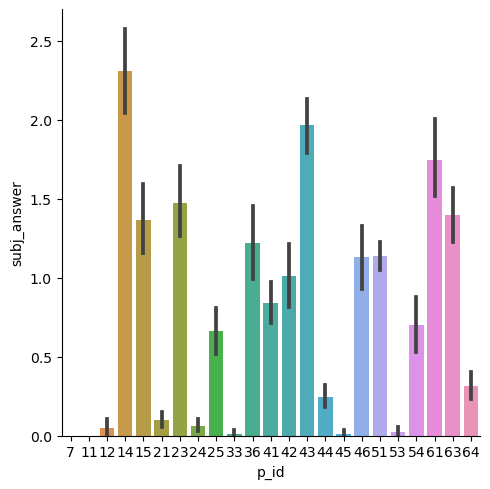

In [10]:
# 1.1.1
sb.catplot(data=all_trials, kind='bar', x='p_id', y='subj_answer')
average_answers_p = pd.DataFrame(all_trials.groupby('p_id', as_index=False)['subj_answer'].mean())
display(average_answers_p)

### Over Blocks

Text(0.5, 0.98, 'Mean subjective answer over blocks')

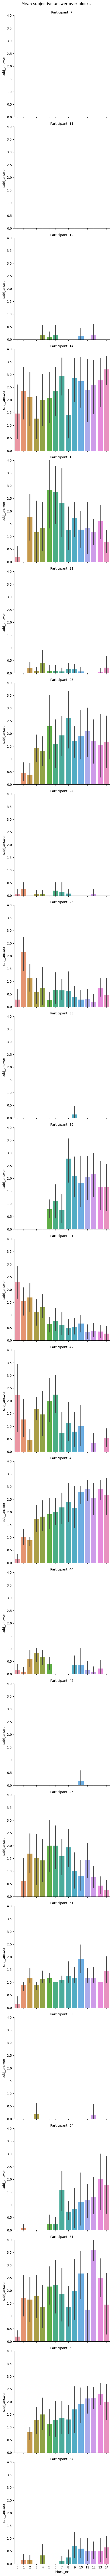

In [11]:
# 1.1.2
ax = sb.catplot(data=all_trials, kind="bar", x="block_nr", y="subj_answer", row="p_id")
ax.set(ylim=(0,4))
ax.set_titles("Participant: {row_name}")
ax.fig.subplots_adjust(top=.975)
ax.fig.suptitle("Mean subjective answer over blocks")

In [12]:
blocked_answers_df = all_trials.groupby(['p_id', 'block_nr'], as_index=False)['subj_answer'].mean()
blocked_answers = [blocked_answers_df[blocked_answers_df['block_nr'] == b]['subj_answer'] for b in range(15)]
print(st.friedmanchisquare(*blocked_answers))

FriedmanchisquareResult(statistic=27.58762886597927, pvalue=0.016130349975342666)


In [13]:
# ANOVA over burst force pr_error for each participant
blocked_answers_anova = pd.DataFrame()
for p_id in p_ids:
    # ANOVA
    data = all_trials[(all_trials['subj_answer'].notna()) & (all_trials['p_id'] == p_id)]
    blocked_answers = [data[data['block_nr']==b]['subj_answer'] for b in range (15)]
    anova = st.f_oneway(*blocked_answers)
    
    blocked_answers_anova = pd.concat([blocked_answers_anova, pd.DataFrame([{'p_id': p_id,
                                                                             'pvalue': anova.pvalue,
                                                                             'anova_significant': anova.pvalue < 0.05,
                                                                             'statistic': anova.statistic}])])
    
display(blocked_answers_anova)

p_id        pvalue  anova_significant  statistic
0     7           NaN              False        NaN
0    11           NaN              False        NaN
0    12  7.542593e-01              False   0.717938
0    14  1.156369e-01              False   1.498799
0    15  3.749454e-03               True   2.505603
0    21  2.371424e-01              False   1.258657
0    23  9.100461e-04               True   2.798220
0    24  3.554239e-01              False   1.105833
0    25  6.828885e-06               True   3.984009
0    33  5.818059e-01              False   0.879764
0    36  1.194125e-09               True   6.231151
0    41  3.947101e-12               True   7.461422
0    42  3.256749e-06               True   4.177961
0    43  2.368121e-13               True   8.416703
0    44  2.016263e-06               True   4.305026
0    45  3.681778e-01              False   1.092335
0    46  6.428703e-05               True   3.429206
0    51  1.407588e-06               True   4.378043
0    53  4.884991e-01              False   0.967841
0    54  2.138246e-08               True   5.415607
0    61  3.210800e-03               True   2.497954
0    63  3.443946e-10               True   6.428699
0    64  3.609553e-03               True   2.444718

## Disturbtion force und subjective answer

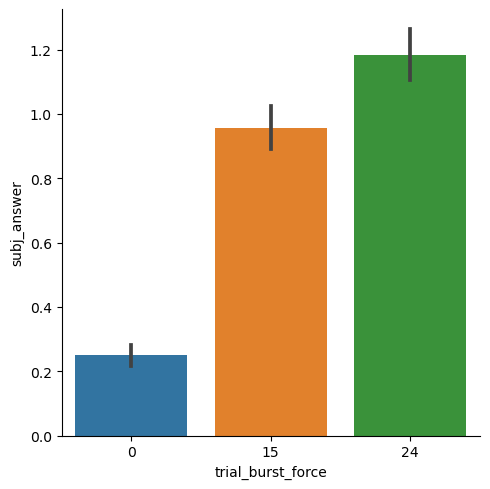

In [64]:
# 1.2.1 ans(force)
all_trials_abs_f = all_trials.copy()
all_trials_abs_f['trial_burst_force'] = all_trials_abs_f['trial_burst_force'].abs()
#all_trials_abs_f_avg = pd.DataFrame(all_trials_abs_f.groupby(['p_id', 'trial_burst_force'], as_index=False)['subj_answer'].mean())
#plot121 = sb.catplot(data=all_trials_abs_f_avg, kind='bar', hue='trial_burst_force', y='subj_answer', x='p_id')
sb.catplot(data=all_trials_abs_f, kind='bar', x='trial_burst_force', y='subj_answer')
plt.savefig("force_and_answer.png")

In [15]:
average_answers_force = pd.DataFrame(all_trials.groupby(['p_id', 'trial_burst_force'], as_index=False)['subj_answer'].mean())

print("Friedman Test (comparing ranks) using the average response for each force intensity.\n")
#display(average_answers_force)
no_force = np.array(average_answers_force[average_answers_force['trial_burst_force']==0]['subj_answer'])
med_force = np.array(average_answers_force[average_answers_force['trial_burst_force']==15]['subj_answer'])
high_force = np.array(average_answers_force[average_answers_force['trial_burst_force']==24]['subj_answer'])
print(st.friedmanchisquare(no_force, med_force, high_force))

Friedman Test (comparing ranks) using the average response for each force intensity.

FriedmanchisquareResult(statistic=19.89473684210523, pvalue=4.7853398380430855e-05)


**Interpretation**: The classes are significantly different from each other.

In [16]:
print("Wilcoxon Signed-Rank Test between the different classes.\n")
print("Between f=0 and f=15:")
print(st.wilcoxon(no_force-med_force, alternative='less', method='approx'))
print("Between f=0 and f=24:")
print(st.wilcoxon(no_force-high_force, alternative='less', method='approx'))
print("Between f=15 and f=24:")
print(st.wilcoxon(med_force-high_force, alternative='less', method='approx'))

Wilcoxon Signed-Rank Test between the different classes.

Between f=0 and f=15:
WilcoxonResult(statistic=5.0, pvalue=0.00014628219220096648)
Between f=0 and f=24:
WilcoxonResult(statistic=11.0, pvalue=0.00036197674999442655)
Between f=15 and f=24:
WilcoxonResult(statistic=42.0, pvalue=0.01646024907528217)


**Interpretation**: Subjective answer when force is present is significantly higher than when not, and for a stronger force it is significantly higher than for a medium force.

# Proprioceptive Reporting (PR)

In [17]:
# Filter out Outliers
all_trials_no_out = all_trials[all_trials['pr_outlier'] == False].copy()

In [18]:
# Datenstaz 63 rausschmeissen
indx = p_ids.index(63)
#del main_trials[indx], begin_trials[indx], end_trials[indx], train1_trials[indx], train2_trials[indx], p_ids[indx]
all_trials_no_out = all_trials_no_out[all_trials_no_out['p_id'] != 63]
all_begin = all_begin[all_begin['p_id'] != 63]
all_end = all_end[all_end['p_id'] != 63]
all_train1 = all_train1[all_train1['p_id'] != 63]
all_train2 = all_train2[all_train2['p_id'] != 63]

## Baseline and zero-force mean

In [19]:
avg_mouse_pos = pd.DataFrame(all_begin.groupby(['p_id', 'pr_target'], as_index=False)['pr_mouse_pos_x'].mean())
avg_mouse_pos.rename({'pr_mouse_pos_x': 'begin_baseline'}, axis=1, inplace=True)
avg_mouse_pos['zero_force'] = list(all_trials_no_out[all_trials_no_out['trial_burst_force']==0].groupby(['p_id', 'pr_target'])['pr_mouse_pos_x'].mean())
avg_mouse_pos['end_baseline'] = list(all_end.groupby(['p_id', 'pr_target'])['pr_mouse_pos_x'].mean())
avg_mouse_pos['comp_value'] = (avg_mouse_pos['begin_baseline'] + avg_mouse_pos['end_baseline'])/2
#display(avg_mouse_pos)
melted = pd.melt(avg_mouse_pos, id_vars=['p_id', 'pr_target'], value_vars=['begin_baseline', 'zero_force', 'end_baseline'], var_name='condition', value_name='avg_x')
#display(melted[60:120])

for pos in melted['pr_target'].unique():
    print(pos, AnovaRM(data=melted[melted['pr_target']==pos], depvar='avg_x', subject='p_id', within=['condition']).fit())

[-266, -266]                  Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition  1.8460 2.0000 42.0000 0.1704

[-266, 266]                  Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition  2.9446 2.0000 42.0000 0.0636

[266, -266]                  Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition  2.6810 2.0000 42.0000 0.0802

[266, 266]                  Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition  5.2205 2.0000 42.0000 0.0094



**Interpretation**: In den meisten fällen unterscheiden sich die click-positionen zwischen den baselines und zero_force mean nicht. Das ist gut, denn es heißt, wir bleiben an den Daten auch wenn wir die baselines verwenden.

In [20]:
# T-Test um zu schauen, ob es sich verändert hat
avg_x_click_ttest = pd.DataFrame()
for p_id, m_trial, b_trial, e_trial in zip(p_ids, main_trials, begin_trials, end_trials):
    if p_id == 63:
        continue
    for pos in m_trial['pr_target'].unique():
        zero_force_x = m_trial[(m_trial['trial_burst_force'] == 0) & (m_trial['pr_target'] == pos)]['pr_mouse_pos_x']
        b_x = b_trial[b_trial['pr_target'] == pos]['pr_mouse_pos_x']
        e_x = e_trial[e_trial['pr_target'] == pos]['pr_mouse_pos_x']
        s_b_e = st.ttest_ind(b_x, e_x)
        s_z_b = st.ttest_ind(zero_force_x, b_x)
        s_z_e = st.ttest_ind(zero_force_x, e_x)
        avg_x_click_ttest = pd.concat([avg_x_click_ttest, pd.DataFrame([{'p_id': p_id,
                                                                         'pr_target': pos,
                                                                         'pv_begin_end': s_b_e.pvalue,
                                                                         'b_e_signif': s_b_e.pvalue < 0.05,
                                                                         'pv_zero_begin': s_z_b.pvalue,
                                                                         'z_b_signif': s_z_b.pvalue < 0.05,
                                                                         'pv_zero_end': s_z_e.pvalue,
                                                                         'z_e_signif': s_z_e.pvalue < 0.05,}])])
    
display(avg_x_click_ttest[(avg_x_click_ttest['b_e_signif']) | (avg_x_click_ttest['z_b_signif']) | (avg_x_click_ttest['z_e_signif'])])

p_id     pr_target  pv_begin_end  b_e_signif  pv_zero_begin  z_b_signif  \
0     7   [-266, 266]      0.226029       False   1.961408e-02        True   
0     7  [-266, -266]      0.976730       False   3.209825e-02        True   
0    11   [-266, 266]      0.208414       False   2.528787e-02        True   
0    11  [-266, -266]      0.000707        True   1.304748e-05        True   
0    12  [-266, -266]      0.004050        True   2.161171e-03        True   
0    12   [266, -266]      0.160730       False   1.927212e-01       False   
0    14   [266, -266]      0.511092       False   2.641048e-01       False   
0    14  [-266, -266]      0.022713        True   5.027057e-02       False   
0    14    [266, 266]      0.274053       False   1.153462e-04        True   
0    14   [-266, 266]      0.804347       False   2.347964e-02        True   
0    15   [-266, 266]      0.000631        True   3.133837e-04        True   
0    15    [266, 266]      0.480470       False   1.474597e-01       False   
0    15  [-266, -266]      0.055537       False   3.646612e-01       False   
0    21   [-266, 266]      0.314951       False   7.933695e-01       False   
0    23    [266, 266]      0.023160        True   7.416747e-01       False   
0    24   [-266, 266]      0.000024        True   1.449741e-03        True   
0    24   [266, -266]      0.357470       False   1.354625e-08        True   
0    24    [266, 266]      0.035566        True   4.561794e-07        True   
0    24  [-266, -266]      0.004237        True   1.234898e-01       False   
0    25   [-266, 266]      0.224133       False   9.693802e-03        True   
0    25  [-266, -266]      0.519884       False   1.810100e-03        True   
0    25    [266, 266]      0.029235        True   3.348460e-01       False   
0    33   [266, -266]      0.042019        True   9.669299e-01       False   
0    36   [-266, 266]      0.116627       False   9.194094e-03        True   
0    36    [266, 266]      0.008786        True   1.580765e-03        True   
0    36   [266, -266]      0.021745        True   2.186701e-03        True   
0    41   [-266, 266]      0.001609        True   4.122086e-03        True   
0    41  [-266, -266]      0.000324        True   8.023113e-04        True   
0    41    [266, 266]      0.012015        True   2.692091e-01       False   
0    41   [266, -266]      0.021269        True   3.607391e-01       False   
0    42   [-266, 266]      0.008929        True   5.355995e-07        True   
0    42   [266, -266]      0.108846       False   4.528039e-08        True   
0    42    [266, 266]      0.758683       False   6.601930e-06        True   
0    42  [-266, -266]      0.818549       False   2.173281e-08        True   
0    43    [266, 266]      0.793923       False   4.329269e-04        True   
0    43  [-266, -266]      0.006200        True   8.789942e-01       False   
0    43   [266, -266]      0.941070       False   4.792345e-03        True   
0    44    [266, 266]      0.127593       False   4.782015e-02        True   
0    45  [-266, -266]      0.779383       False   6.570626e-02       False   
0    45   [266, -266]      0.194002       False   6.395740e-01       False   
0    46   [-266, 266]      0.029385        True   7.476271e-01       False   
0    46  [-266, -266]      0.031883        True   1.747747e-01       False   
0    46    [266, 266]      0.076304       False   7.368985e-01       False   
0    51   [-266, 266]      0.019113        True   1.513574e-02        True   
0    51   [266, -266]      0.444191       False   6.003804e-06        True   
0    51  [-266, -266]      0.150893       False   2.834271e-04        True   
0    53    [266, 266]      0.438671       False   1.586673e-01       False   
0    53   [-266, 266]      0.632111       False   8.867055e-02       False   
0    53  [-266, -266]      0.000931        True   4.244819e-01       False   
0    54  [-266, -266]      0.014349        True   4.234638e-01       False   
0    54   [266, -266]    

**Interpretation**: Oft unterscheidet sich die Durchführung in den baselines und während des experiments. D.h. Performance verändert sich über Zeit, was wir gewissermaßen auch erwartet haben. Daher möchten wir nun bei der analyse das mittel von beiden Baselines als Vergleichswert verwenden.

## Adaptation

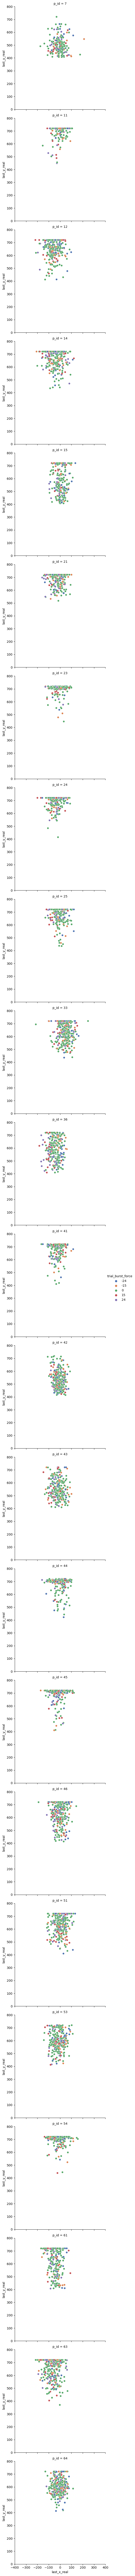

In [21]:
# 2.4.1
plot241 = sb.relplot(data=all_trials, x='last_x_real', y='last_y_real', row='p_id', hue='trial_burst_force', palette='deep')
plot241.set(ylim=(0,800), xlim=[-400,400])
avg_x = pd.DataFrame(all_trials.groupby(['p_id', 'trial_burst_force'], as_index=False)['last_x_real'].mean())

In [22]:
# ANOVA for ending means
print("ANOVA tests regarding the end positions of the actual hand location for different forces.")
last_x_r_anova = pd.DataFrame()
for p_id, trial in zip(p_ids, main_trials):
    anova = st.f_oneway(trial[trial['trial_burst_force']==-24]['last_x_real'], 
                       trial[trial['trial_burst_force']==-15]['last_x_real'], 
                       trial[trial['trial_burst_force']==0]['last_x_real'], 
                       trial[trial['trial_burst_force']==15]['last_x_real'], 
                       trial[trial['trial_burst_force']==24]['last_x_real'], )
    last_x_r_anova = pd.concat([last_x_r_anova, pd.DataFrame([{'p_id': p_id, 
                                                             'pvalue': anova.pvalue, 
                                                             'statistic': anova.statistic,
                                                              'significant': anova.pvalue < 0.05}])])
    
display(last_x_r_anova)
sss_scores['adaptation_statistic'] = last_x_r_anova['statistic']

ANOVA tests regarding the end positions of the actual hand location for different forces.


p_id        pvalue  statistic  significant
0     7  2.818425e-02   2.783130         True
0    11  4.243155e-01   0.969913        False
0    12  1.435949e-01   1.729237        False
0    14  6.984045e-01   0.551046        False
0    15  6.063129e-03   3.712484         True
0    21  3.110488e-07   9.499115         True
0    23  2.132129e-01   1.464067        False
0    24  1.975472e-02   2.972706         True
0    25  3.516486e-06   8.072534         True
0    33  1.083067e-01   1.912948        False
0    36  4.818885e-17  24.243244         True
0    41  2.144668e-01   1.459992        False
0    42  5.796886e-01   0.718847        False
0    43  1.110010e-05   7.435017         True
0    44  7.538014e-01   0.475381        False
0    45  2.578981e-01   1.332582        False
0    46  2.735824e-03   4.158112         True
0    51  1.572385e-01   1.669378        False
0    53  2.011194e-06   8.430747         True
0    54  5.052989e-01   0.832677        False
0    61  4.903367e-03   3.828369         True
0    63  6.256062e-01   0.652409        False
0    64  6.996511e-01   0.549342        False

**Interpretation**: Manchmal unterscheiden sich die means der realen endpositionen. Wenn dies der Fall ist könnte das heißen, dass eine Anpassung stattgefunden hat.

In [23]:
for p_id in p_ids:
    if p_id == 63:
        continue
    all_trials_no_out.loc[all_trials_no_out['p_id'] == p_id, 'adaptation_statistic'] = np.round(last_x_r_anova[last_x_r_anova['p_id'] == p_id]['statistic'].iloc[0], 2)

## Leistung nach Force

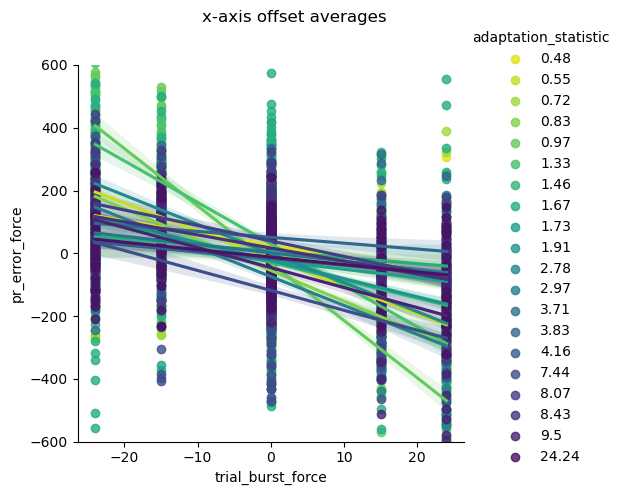

In [24]:
# 2.2
for i, row in all_trials_no_out.iterrows():
    comp_value = avg_mouse_pos[(avg_mouse_pos['p_id'] == row['p_id']) & (avg_mouse_pos['pr_target'] == row['pr_target'])]['comp_value'].iloc[0]
    all_trials_no_out.loc[i,'pr_error_force'] = row['pr_mouse_pos_x'] - comp_value
    
plot22 = sb.lmplot(data=all_trials_no_out, x="trial_burst_force", y="pr_error_force", hue="adaptation_statistic", palette='viridis_r')
plot22.fig.subplots_adjust(top=.87)
plot22.fig.suptitle("x-axis offset averages")
plot22.set(ylim=(-600,600))

In [25]:
# ANOVA over burst force pr_error for each participant
pr_error_force = pd.DataFrame()
for p_id in p_ids:
    if p_id == 63:
        continue
    # ANOVA
    err_n24 = all_trials_no_out[(all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['trial_burst_force'] == -24)]['pr_error_force']
    err_n15 = all_trials_no_out[(all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['trial_burst_force'] == -15)]['pr_error_force']
    err_0 = all_trials_no_out[(all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['trial_burst_force'] == 0)]['pr_error_force']
    err_15 = all_trials_no_out[(all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['trial_burst_force'] == 15)]['pr_error_force']
    err_24 = all_trials_no_out[(all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['trial_burst_force'] == 24)]['pr_error_force']
    anova = st.f_oneway(err_n24, err_n15, err_0, err_15, err_24)
    
    # slopes
    x = [-24 for i in range(len(err_n24))] + [-15 for i in range(len(err_n15))] + [0 for i in range(len(err_0))] + [15 for i in range(len(err_15))] + [24 for i in range(len(err_24))]
    y = list(err_n24) + list(err_n15) + list(err_0) + list(err_15) + list(err_24)
    slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
    
    pr_error_force = pd.concat([pr_error_force, pd.DataFrame([{'p_id': p_id,
                                                                   'pvalue': anova.pvalue,
                                                                   'anova_significant': anova.pvalue < 0.05,
                                                                   'statistic': anova.statistic,
                                                                   'slope': slope,
                                                                   'pearson_r': r_value,
                                                                   'pearson_p': p_value,
                                                                   'pearson_significant': p_value < 0.05}])])
    
display(pr_error_force)

p_id         pvalue  anova_significant   statistic      slope  pearson_r  \
0     7   9.772477e-50               True  121.805076  -9.268399  -0.846640   
0    11  1.330868e-103               True  318.317263 -18.250754  -0.903204   
0    12   1.475531e-06               True    8.599367  -2.721748  -0.318167   
0    14   1.101738e-53               True  101.006516  -9.501978  -0.760165   
0    15   4.079948e-04               True    5.340598  -2.636516  -0.272169   
0    21   4.387739e-39               True   64.926608  -6.369699  -0.655406   
0    23   3.555268e-23               True   34.033496  -6.455553  -0.557734   
0    24   2.738210e-37               True   60.675209  -9.212554  -0.654106   
0    25   9.650264e-12               True   15.894401  -4.924287  -0.425793   
0    33   8.895322e-48               True   86.156231  -5.766485  -0.736744   
0    36   1.078846e-05               True    7.453474  -2.364604  -0.282058   
0    41   1.082886e-28               True   43.822205  -4.964625  -0.604937   
0    42   2.184694e-02               True    2.917632  -2.101259  -0.130782   
0    43   9.812662e-16               True   22.189997  -6.341094  -0.491305   
0    44   6.026560e-12               True   16.314654  -3.938183  -0.429276   
0    45   2.016480e-68               True  148.776821 -13.209627  -0.815665   
0    46   2.361896e-09               True   12.469606  -2.162408  -0.352855   
0    51   4.351073e-01              False    0.950681  -1.961529  -0.094810   
0    53   7.808861e-21               True   30.364632  -4.166924  -0.537911   
0    54   1.694770e-62               True  129.683931  -9.821904  -0.799160   
0    61   1.954307e-02               True    2.991059  -1.868123  -0.202477   
0    64   5.749850e-66               True  139.857460  -8.090516  -0.810525   

       pearson_p  pearson_significant  
0   3.416924e-51                 True  
0  1.963565e-107                 True  
0   4.222101e-08                 True  
0   1.273287e-56                 True  
0   5.043045e-05                 True  
0   2.399438e-37                 True  
0   7.321037e-25                 True  
0   9.106278e-38                 True  
0   5.044549e-14                 True  
0   1.588740e-50                 True  
0   3.669994e-06                 True  
0   1.563694e-30                 True  
0   3.299739e-02                 True  
0   3.329525e-17                 True  
0   2.135874e-13                 True  
0   3.521729e-70                 True  
0   7.718167e-10                 True  
0   1.121405e-01                False  
0   8.414429e-22                 True  
0   1.651279e-64                 True  
0   1.508909e-03                 True  
0   7.138931e-69                 True

**Interpretation**: For all participants the performance on the click task varied with the burst force. The slope is negative for every participant, meaning that disturbances in the left direction cause errors to the right and vice versa.

### Adaptation und Leistung

In [26]:
x = np.round(list(last_x_r_anova['statistic']), 5).tolist()
x.remove(np.round(last_x_r_anova[last_x_r_anova['p_id'] == 63]['statistic'].iloc[0], 5))
y = pr_error_force['slope']
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
print(f"Correlation between adaptation and error slope\nSlope: {slope}    p-value: {p_value}")

Correlation between adaptation and error slope
Slope: 0.23337344045430755    p-value: 0.17767400074873582


**Interpretation**: The degree of adaptation performed does not have an effect on the performance.

## Leistung nach Subjective Answer

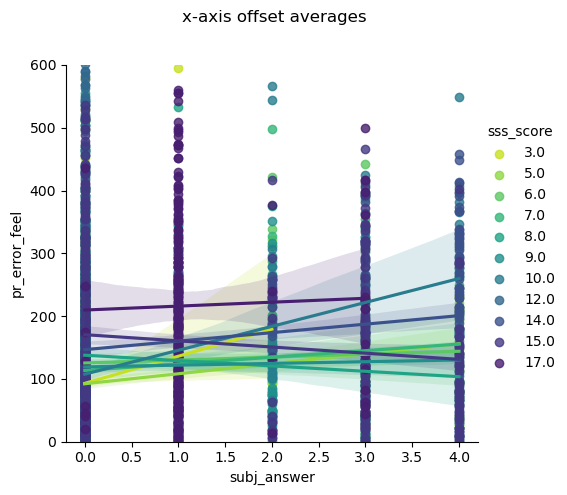

In [27]:
# 2.3.2
all_trials_no_out['pr_error_feel'] = all_trials_no_out['pr_error_force'].abs()

plot232 = sb.lmplot(data=all_trials_no_out, x="subj_answer", y="pr_error_feel", hue="sss_score", palette='viridis_r')
plot232.fig.subplots_adjust(top=.87)
plot232.fig.suptitle("x-axis offset averages")
plot232.set(ylim=(0,600))

In [28]:
# ANOVA over subj answer pr_error for each participant
pr_error_feel = pd.DataFrame()
for p_id, f in itertools.product(p_ids, all_trials_no_out['trial_burst_force'].unique()):
    if p_id == 63:
        continue
    # ANOVA
    data = all_trials_no_out[(all_trials_no_out['trial_burst_force'] == f) & (all_trials_no_out['p_id'] == p_id)].copy()
    err_0 = data[data['subj_answer'] == 0]['pr_error_feel']
    err_1 = data[(data['subj_answer'] == 1)]['pr_error_feel']
    err_2 = data[(data['subj_answer'] == 2)]['pr_error_feel']
    err_3 = data[(data['subj_answer'] == 3)]['pr_error_feel']
    err_4 = data[(data['subj_answer'] == 4)]['pr_error_feel']
    errs = [err_0, err_1, err_2, err_3, err_4]
    fil = [len(err) > 0 for err in errs]
    try:
        anova = st.f_oneway(*list(itertools.compress(errs, fil)))

        # slopes
        x = [0 for i in range(len(err_0))] + [1 for i in range(len(err_1))] + [2 for i in range(len(err_2))] + [3 for i in range(len(err_3))] + [4 for i in range(len(err_4))]
        y = list(err_0) + list(err_1) + list(err_2) + list(err_3) + list(err_4)
        slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

        pr_error_feel = pd.concat([pr_error_feel, pd.DataFrame([{'p_id': p_id,
                                                               'trial_burst_force': f,
                                                               'pvalue': anova.pvalue,
                                                               'anova_significant': anova.pvalue < 0.05,
                                                               'statistic': anova.statistic,
                                                               'slope': slope,
                                                               'pearson_r': r_value,
                                                               'pearson_p': p_value,
                                                               'pearson_significant': p_value < 0.05}])])
    except TypeError:
        continue
#display(pr_error_feel[pr_error_feel['pearson_significant']])
display(pr_error_feel)

p_id  trial_burst_force    pvalue  anova_significant  statistic  \
0     12                  0  0.728415              False   0.318623   
0     12                -15  0.851594              False   0.035678   
0     12                 24  0.843300              False   0.039834   
0     14                  0  0.061092              False   2.379002   
0     14                -15  0.490619              False   0.828654   
..   ...                ...       ...                ...        ...   
0     61                 24  0.008683               True   5.112789   
0     64                -15  0.749103              False   0.292113   
0     64                -24  0.415249              False   0.909267   
0     64                 15  0.920476              False   0.083129   
0     64                 24  0.724996              False   0.325599   

        slope  pearson_r  pearson_p  pearson_significant  
0  -15.002534  -0.065648   0.615203                False  
0   -6.203704  -0.036327   0.851594                False  
0   -7.427679  -0.038382   0.843300                False  
0    1.914349   0.035609   0.773124                False  
0   17.487466   0.131463   0.496650                False  
..        ...        ...        ...                  ...  
0   -5.336842  -0.096736   0.652952                False  
0   10.273092   0.122660   0.526153                False  
0    2.139199   0.018576   0.923806                False  
0    0.425774   0.002904   0.988070                False  
0   23.251440   0.149356   0.439356                False  

[85 rows x 9 columns]

**Interpretation**: Die Korrelation ist nicht signifikant. D.h. die Leistung hängt nicht immer mit dem subjektiven Gefühl zusammen. Dies könnte bedeuten, dass durch das Gefühl nicht die Position-Schätzung beeinflusst wird.

# Korrigierte PR Ergebnisse (KorrPR)

In [29]:
all_trials_no_out['burst_offset'] = all_trials_no_out['last_x_v'] - all_trials_no_out['last_x_real']
all_trials_no_out['v_pr_x'] = all_trials_no_out['pr_mouse_pos_x'] + all_trials_no_out['burst_offset']

## Leistung KorrPR nach Force

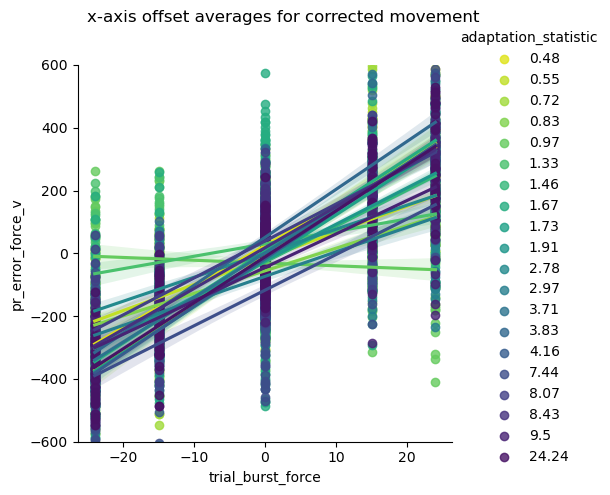

In [30]:
for i, row in all_trials_no_out.iterrows():
    all_trials_no_out.loc[i,'pr_error_force_v'] = row['v_pr_x'] - avg_mouse_pos[(avg_mouse_pos['p_id'] == row['p_id']) & (avg_mouse_pos['pr_target'] == row['pr_target'])]['comp_value'].iloc[0]
    
plot22 = sb.lmplot(data=all_trials_no_out, x="trial_burst_force", y="pr_error_force_v", hue="adaptation_statistic", palette='viridis_r')
plot22.fig.subplots_adjust(top=.87)
plot22.fig.suptitle("x-axis offset averages for corrected movement")
plot22.set(ylim=(-600,600))

In [31]:
# ANOVA over burst force pr_error of corrected movement for each participant
v_pr_error_force = pd.DataFrame()
for p_id in p_ids:
    if p_id == 63:
        continue
    # ANOVA
    err_n24 = all_trials_no_out[(all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['trial_burst_force'] == -24)]['pr_error_force_v']
    err_n15 = all_trials_no_out[(all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['trial_burst_force'] == -15)]['pr_error_force_v']
    err_0 = all_trials_no_out[(all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['trial_burst_force'] == 0)]['pr_error_force_v']
    err_15 = all_trials_no_out[(all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['trial_burst_force'] == 15)]['pr_error_force_v']
    err_24 = all_trials_no_out[(all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['trial_burst_force'] == 24)]['pr_error_force_v']
    anova = st.f_oneway(err_n24, err_n15, err_0, err_15, err_24)
    
    # slopes
    x = [-24 for i in range(len(err_n24))] + [-15 for i in range(len(err_n15))] + [0 for i in range(len(err_0))] + [15 for i in range(len(err_15))] + [24 for i in range(len(err_24))]
    y = list(err_n24) + list(err_n15) + list(err_0) + list(err_15) + list(err_24)
    slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
    
    v_pr_error_force = pd.concat([v_pr_error_force, pd.DataFrame([{'p_id': p_id,
                                                                   'pvalue': anova.pvalue,
                                                                   'anova_significant': anova.pvalue < 0.05,
                                                                   'statistic': anova.statistic,
                                                                   'slope': slope,
                                                                   'pearson_r': r_value,
                                                                   'pearson_p': p_value,
                                                                   'pearson_significant': p_value < 0.05}])])
    
display(v_pr_error_force)

p_id         pvalue  anova_significant   statistic      slope  pearson_r  \
0     7   6.180528e-40               True   84.268173   7.653826   0.798794   
0    11   2.352147e-01              False    1.396653  -0.889081  -0.102138   
0    12   1.077167e-85               True  223.466578  14.651304   0.871515   
0    14   1.304441e-39               True   66.012274   7.631391   0.686643   
0    15   9.246332e-54               True  122.101661  14.220200   0.832336   
0    21   4.126206e-75               True  172.262115  10.659448   0.826000   
0    23   2.909193e-49               True   90.164426  10.674807   0.741890   
0    24   8.055696e-29               True   43.834598   7.806632   0.589854   
0    25   1.049747e-48               True   88.845354  11.775196   0.746236   
0    33  9.958197e-108               True  346.675273  11.599450   0.909318   
0    36   7.467362e-82               True  221.508319  14.659643   0.876609   
0    41   5.388798e-93               True  254.171310  12.171788   0.880818   
0    42   3.980720e-36               True   60.548603  15.081523   0.684896   
0    43   3.961776e-38               True   65.695185  11.344548   0.704042   
0    44   1.301793e-69               True  162.092033  13.054278   0.840300   
0    45   6.736523e-12               True   16.104377   3.965011   0.389404   
0    46  9.792404e-126               True  491.366527  15.165517   0.932869   
0    51   6.422047e-24               True   35.464357  14.683165   0.579439   
0    53   2.077791e-93               True  275.187150  13.014779   0.893888   
0    54   2.976321e-41               True   70.542219   7.193307   0.695599   
0    61   1.624102e-68               True  169.883690  15.281658   0.859510   
0    64   1.241318e-74               True  171.696698   9.037729   0.837543   

       pearson_p  pearson_significant  
0   1.399432e-41                 True  
0   8.303317e-02                False  
0   2.904160e-89                 True  
0   2.498151e-42                 True  
0   9.368284e-57                 True  
0   1.996773e-74                 True  
0   2.139201e-51                 True  
0   2.559867e-29                 True  
0   4.059375e-52                 True  
0  6.393422e-111                 True  
0   2.981877e-84                 True  
0   3.598059e-96                 True  
0   3.604979e-38                 True  
0   3.133314e-40                 True  
0   1.996998e-72                 True  
0   6.695045e-12                 True  
0  2.109241e-128                 True  
0   1.092508e-26                 True  
0   4.523121e-96                 True  
0   1.543843e-42                 True  
0   3.383267e-72                 True  
0   1.395486e-77                 True

**Interpretation**: Alle sind signifikant. Das heißt es gibt immer einen unterschied zwischen der no_force und den force Bewegungen mit kompensiertem offset. Das heißt der Task wurde nicht visuell optimal ausgeführt. Dies könnte bedeuten, dass auch die propriozeptive Information wichtig war.

## Leistung KorrPR nach Subjective Answer

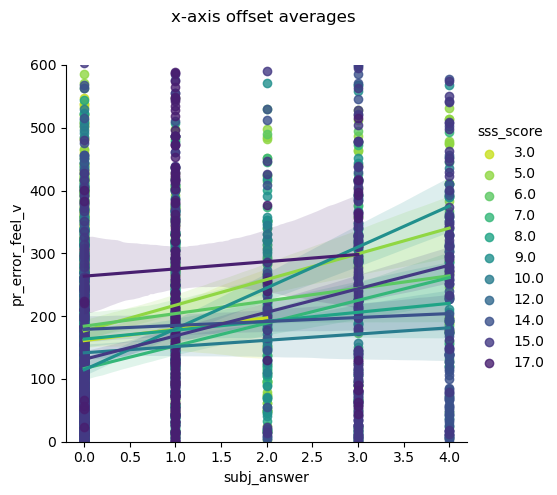

In [32]:
all_trials_no_out['pr_error_feel_v'] = all_trials_no_out['pr_error_force_v'].abs()

plot232 = sb.lmplot(data=all_trials_no_out, x="subj_answer", y="pr_error_feel_v", hue="sss_score", palette='viridis_r')
plot232.fig.subplots_adjust(top=.87)
plot232.fig.suptitle("x-axis offset averages")
plot232.set(ylim=(0,600))

In [33]:
# ANOVA over subj answer corrected pr_error for each participant
pr_error_feel_v = pd.DataFrame()
for p_id in p_ids:
    if p_id == 63:
        continue
    # ANOVA
    err_0 = all_trials_no_out[(all_trials_no_out['trial_burst_force'] != 0) & (all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['subj_answer'] == 0)]['pr_error_feel_v']
    err_1 = all_trials_no_out[(all_trials_no_out['trial_burst_force'] != 0) & (all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['subj_answer'] == 1)]['pr_error_feel_v']
    err_2 = all_trials_no_out[(all_trials_no_out['trial_burst_force'] != 0) & (all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['subj_answer'] == 2)]['pr_error_feel_v']
    err_3 = all_trials_no_out[(all_trials_no_out['trial_burst_force'] != 0) & (all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['subj_answer'] == 3)]['pr_error_feel_v']
    err_4 = all_trials_no_out[(all_trials_no_out['trial_burst_force'] != 0) & (all_trials_no_out['p_id'] == p_id) & (all_trials_no_out['subj_answer'] == 4)]['pr_error_feel_v']
    errs = [err_0, err_1, err_2, err_3, err_4]
    fil = [len(err) > 0 for err in errs]
    try:
        anova = st.f_oneway(*list(itertools.compress(errs, fil)))

        # slopes
        x = [0 for i in range(len(err_0))] + [1 for i in range(len(err_1))] + [2 for i in range(len(err_2))] + [3 for i in range(len(err_3))] + [4 for i in range(len(err_4))]
        y = list(err_0) + list(err_1) + list(err_2) + list(err_3) + list(err_4)
        slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

        pr_error_feel_v = pd.concat([pr_error_feel_v, pd.DataFrame([{'p_id': p_id,
                                                               'pvalue': anova.pvalue,
                                                               'anova_significant': anova.pvalue < 0.05,
                                                               'statistic': anova.statistic,
                                                               'slope': slope,
                                                               'pearson_r': r_value,
                                                               'pearson_p': p_value,
                                                               'pearson_significant': p_value < 0.05}])])
    except TypeError:
        continue
    
display(pr_error_feel_v)

p_id    pvalue  anova_significant  statistic      slope  pearson_r  \
0    12  0.461112              False   0.546955 -29.808784  -0.069712   
0    14  0.930287              False   0.213833   8.827424   0.072706   
0    15  0.000882               True   5.238753  47.027424   0.376050   
0    21  0.546471              False   0.607546 -31.542827  -0.103579   
0    23  0.243946              False   1.385058  14.222976   0.141555   
0    24  0.595097              False   0.521381   8.095225   0.019756   
0    25  0.931097              False   0.212345  -1.415562  -0.011292   
0    33  0.281368              False   1.171747  53.747788   0.101753   
0    36  0.001735               True   4.658152   5.709233   0.057808   
0    41  0.603560              False   0.685363 -14.788060  -0.119331   
0    42  0.258944              False   1.343429  13.143038   0.086890   
0    43  0.506747              False   0.834032  -8.532529  -0.055994   
0    44  0.242563              False   1.435778  14.273300   0.053928   
0    45  0.204849              False   1.626337 -63.209735  -0.119637   
0    46  0.157687              False   1.690158  17.034101   0.206837   
0    51  0.550333              False   0.706399  18.337881   0.045315   
0    53  0.747555              False   0.104171 -13.811500  -0.032259   
0    54  0.912271              False   0.244695   3.083456   0.036973   
0    61  0.030196               True   2.806928   9.693037   0.091885   
0    64  0.651604              False   0.429945  -0.240984  -0.001555   

   pearson_p  pearson_significant  
0   0.461112                False  
0   0.431988                False  
0   0.000541                 True  
0   0.270641                False  
0   0.134768                False  
0   0.831837                False  
0   0.904660                False  
0   0.281368                False  
0   0.559967                False  
0   0.201999                False  
0   0.371228                False  
0   0.574264                False  
0   0.579358                False  
0   0.204849                False  
0   0.029398                 True  
0   0.643022                False  
0   0.747555                False  
0   0.705361                False  
0   0.375829                False  
0   0.986778                False

**Interpretation**: Slopes are mainly not significant. This means that the subjective feeling does not affect how heavily the proprioceptive estimate is weighed / it does not seem to be a good measure of the confidence in the proprioceptive estimate. This does not yield an explanation for the fact that the corrected movement is not ideal.

## Leistung PR vs. Leistung KorrPR

In [63]:
pr_vs_v_pr = pd.DataFrame()
for p_id in p_ids:
    pr_errors = all_trials_no_out[all_trials_no_out['p_id'] == p_id]['pr_error_feel']
    pr_v_errors = all_trials_no_out[all_trials_no_out['p_id'] == p_id]['pr_error_feel_v']
    ttest = st.ttest_ind(pr_errors, pr_v_errors)
    bartlett = st.bartlett(pr_errors, pr_v_errors)
    pr_vs_v_pr = pd.concat([pr_vs_v_pr, pd.DataFrame([{'p_id': p_id,
                                                      'ttest_pvalue': ttest.pvalue,
                                                      'ttest_stat': ttest.statistic,
                                                      'ttest_significant': ttest.pvalue < 0.05,
                                                      'bartlett_pvalue': bartlett.pvalue,
                                                      'bartlett_stat': bartlett.statistic,
                                                      'bartlett_significant': bartlett.pvalue < 0.05,
                                                      'variance_diff': pr_v_errors.var()/pr_errors.var()}])])
    if p_id == 63:
        pr_vs_v_pr.loc[pr_vs_v_pr['p_id']==63, 'ttest_pvalue'] = np.nan
        pr_vs_v_pr.loc[pr_vs_v_pr['p_id']==63, 'ttest_stat'] = np.nan
        pr_vs_v_pr.loc[pr_vs_v_pr['p_id']==63, 'ttest_significant'] = np.nan
        pr_vs_v_pr.loc[pr_vs_v_pr['p_id']==63, 'bartlett_pvalue'] = np.nan
        pr_vs_v_pr.loc[pr_vs_v_pr['p_id']==63, 'bartlett_stat'] = np.nan
        pr_vs_v_pr.loc[pr_vs_v_pr['p_id']==63, 'bartlett_significant'] = np.nan
    
pr_vs_v_pr['adaptor'] = last_x_r_anova['significant']
display(pr_vs_v_pr)

p_id  ttest_pvalue  ttest_stat ttest_significant  bartlett_pvalue  \
0     7  1.834990e-01    1.332607             False     4.508629e-02   
0    11  2.377554e-15    8.144152              True     1.569962e-47   
0    12  1.215415e-15   -8.238514              True     1.169087e-32   
0    14  8.958352e-02    1.700415             False     4.232736e-02   
0    15  3.931976e-09   -6.011279              True     4.031340e-22   
0    21  1.000118e-04   -3.917604              True     4.705817e-04   
0    23  3.497444e-03   -2.932463              True     6.457323e-05   
0    24  9.103301e-01    0.112670             False     3.666621e-02   
0    25  8.518814e-07   -4.978112              True     3.194984e-07   
0    33  4.126666e-08   -5.560494              True     1.783982e-18   
0    36  2.529444e-11   -6.820394              True     7.308186e-36   
0    41  2.596286e-09   -6.049830              True     1.419682e-20   
0    42  1.366886e-04   -3.842240              True     6.793468e-29   
0    43  9.454875e-02   -1.674944             False     5.399928e-05   
0    44  1.956021e-10   -6.491010              True     7.467425e-19   
0    45  7.211536e-08    5.456761              True     1.738331e-17   
0    46  8.471560e-23  -10.263454              True     1.142214e-64   
0    51  1.054541e-02   -2.566018              True     1.771098e-06   
0    53  1.360788e-10   -6.547355              True     3.231137e-30   
0    54  1.521309e-01    1.433971             False     4.606699e-03   
0    61  3.867078e-14   -7.798885              True     3.298858e-23   
0    63           NaN         NaN               NaN              NaN   
0    64  5.942708e-01   -0.532953             False     7.135723e-02   

   bartlett_stat bartlett_significant  variance_diff  adaptor  
0       4.015409                 True       0.741668     True  
0     209.734049                 True       0.163047    False  
0     141.634290                 True       4.375296    False  
0       4.122066                 True       0.788437    False  
0      93.514999                 True       3.931460     True  
0      12.228772                 True       1.508435     True  
0      15.963570                 True       1.608224    False  
0       4.365849                 True       0.784281     True  
0      26.128111                 True       1.841805     True  
0      76.915866                 True       2.885236    False  
0     156.292228                 True       5.109394     True  
0      86.468676                 True       3.059983    False  
0     124.426948                 True       4.162431    False  
0      16.302268                 True       1.656815     True  
0      78.636048                 True       3.051097    False  
0      72.421237                 True       0.358800    False  
0     288.342347                 True       8.869133     True  
0      22.828606                 True       1.776134    False  
0     130.471653                 True       4.243759     True  
0       8.027712                 True       0.713663    False  
0      98.470602                 True       3.746794     True  
0            NaN                  NaN            NaN    False  
0       3.251521                False       1.236796    False

**Interpretation**: In (almost) all cases the error of the PR movement corrected for the offset is significantly larger than the error without correction. This means that the PR task is not performed based solely on visual input, but that actually the proprioceptive estimate seems to play an important role.

# Sensory Suggestibility Scale (SSS)

## SSS und Antwort

Force: -24    Slope: 0.09651109567117543    p-value: 1.9950622260788744e-11
Force: -15    Slope: 0.09315335589716026    p-value: 1.3098437798141822e-13
Force: 0    Slope: 0.058031743677495716    p-value: 4.08582447913571e-40
Force: 15    Slope: 0.09067082002776888    p-value: 1.83425777821408e-13
Force: 24    Slope: 0.08811157365672778    p-value: 1.7795466786464066e-09


Text(0.5, 1.0, 'Score on SSS test vs. average subjective answer')

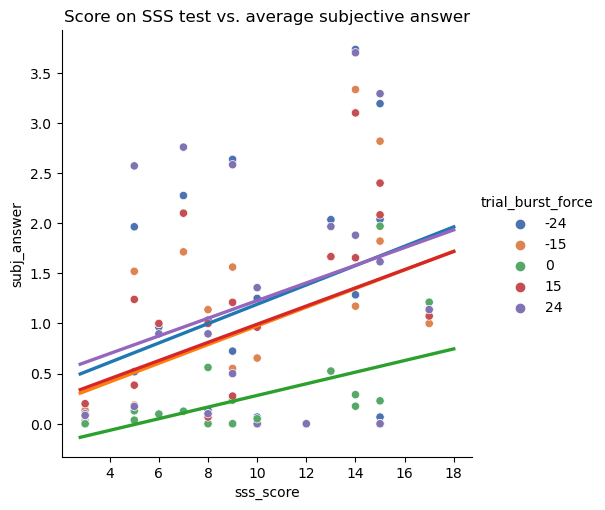

In [35]:
# 3.1

average_force_subj_p = all_trials.groupby(['p_id', 'trial_burst_force'], as_index=False)['subj_answer'].mean()

for p_id in p_ids:
    average_force_subj_p.loc[average_force_subj_p['p_id'] == p_id, 'sss_score'] = sss_scores[sss_scores['p_id'] == p_id]['sss_score'].iloc[0]

sb.relplot(data=average_force_subj_p, x='sss_score', y='subj_answer', hue='trial_burst_force', palette='deep')

# regressions
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
forces = [-24, -15, 0, 15, 24]
x_values = np.linspace(2.8,18,50)
for f,c in zip(forces, colors):
    y = all_trials[(all_trials['trial_burst_force'] == f) & (all_trials['subj_answer'].notna()) & (all_trials['sss_score'].notna())]['subj_answer']
    x = all_trials[(all_trials['trial_burst_force'] == f) & (all_trials['subj_answer'].notna()) & (all_trials['sss_score'].notna())]['sss_score']
    slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
    plt.plot(x_values, x_values * slope + intercept, c=c, lw=2.4)
    print(f"Force: {f}    Slope: {slope}    p-value: {p_value}")


#sb.lmplot(data=all_trials[all_trials['p_id'].isin(responders)], x='sss_score', y='subj_answer')
plt.title('Score on SSS test vs. average subjective answer')

In [36]:
sss_ans_lists = []
for score in all_trials[all_trials['sss_score'].notna()]['sss_score'].unique():
    answers = list(all_trials[(all_trials['sss_score'] == score) & (all_trials['subj_answer'].notna())]['subj_answer'])
    sss_ans_lists.append(answers)

sss_answer_anova = st.f_oneway(*sss_ans_lists)
print('ANOVA regarding the subjective answer for each suggestibility score:')
print(sss_answer_anova)

ANOVA regarding the subjective answer for each suggestibility score:
F_onewayResult(statistic=75.46763432788357, pvalue=1.5727428179500074e-153)


**Interpretation**: The different SSS scores have significantly different average subjective answers. This means there is a correlation. The slope is positive, which means that a higher SSS score correlates with a higher average answer.

## SSS und Leistung

### PR

Text(0.5, 1.0, 'Score on SSS test vs. error in PR task')

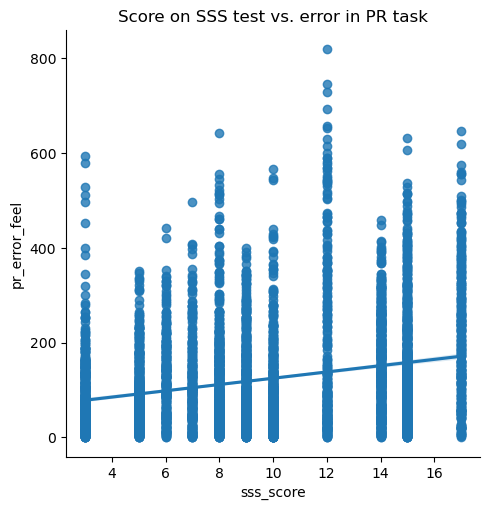

In [37]:
sb.lmplot(data=all_trials_no_out, x='sss_score', y='pr_error_feel')
plt.title('Score on SSS test vs. error in PR task')

In [59]:
sss_err_lists = []
sss_err_xs = []
for score in all_trials_no_out['sss_score'].unique():
    if score == np.nan:
        continue
    errors = list(all_trials_no_out[(all_trials_no_out['sss_score'] == score)]['pr_error_feel'])
    if errors == []:
        continue
    sss_err_lists.append(errors)
    sss_err_xs.append([score for i in range(len(errors))])

sss_error_anova = st.f_oneway(*sss_err_lists)
print('ANOVA regarding the PR error for each suggestibility score:')
print(sss_error_anova)

# slopes
x = [xi for sublist in sss_err_xs for xi in sublist]
y = [yi for sublist in sss_err_lists for yi in sublist]
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
print('Slope, Pearson r and p-value of a linear regression:')
print({'slope': slope, 'pearsonr': r_value, 'p_value': p_value})

ANOVA regarding the PR error for each suggestibility score:
F_onewayResult(statistic=59.89482965256623, pvalue=9.499402929540737e-116)
Slope, Pearson r and p-value of a linear regression:
{'slope': 6.6375419986308355, 'pearsonr': 0.25331365440239706, 'p_value': 2.0734569987784435e-80}


**Interpretation**: Higher SSS score means worse performance on the PR task (because one will feel more like the arm was moved, which influences the clicking movement and worsens it). This may seem to go against plot 2.3.2, as there the subjective feeling does not have a significant impact on the error. However, this may be because the question posed may not be suited to capture the *weird feeling*. That SSS relates to the answer to the question and with a worse performance does not imply that the answer has to relate with the performance, as it may fail to target whatever is actually affecting the performance.

### KorrPR

Text(0.5, 1.0, 'Score on SSS test vs. error in PR task')

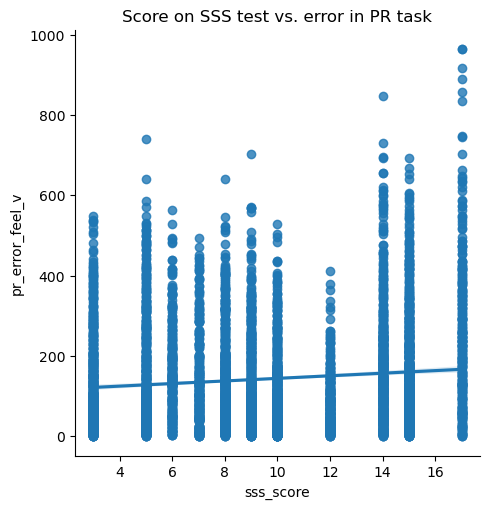

In [39]:
sb.lmplot(data=all_trials_no_out, x='sss_score', y='pr_error_feel_v')
plt.title('Score on SSS test vs. error in PR task')

In [61]:
sss_err_v_lists = []
sss_err_v_xs = []
for score in all_trials_no_out['sss_score'].unique():
    if score == np.nan:
        continue
    errors_v = list(all_trials_no_out[(all_trials_no_out['sss_score'] == score)]['pr_error_feel_v'])
    if errors_v == []:
        continue
    sss_err_v_lists.append(errors_v)
    sss_err_v_xs.append([score for i in range(len(errors_v))])

sss_error_v_anova = st.f_oneway(*sss_err_v_lists)
print('ANOVA regarding the corrected PR error for each suggestibility score:')
print(sss_error_v_anova)

# slopes
x = [xi for sublist in sss_err_v_xs for xi in sublist]
y = [yi for sublist in sss_err_v_lists for yi in sublist]
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
print('Slope, Pearson r and p-value of a linear regression:')
print({'slope': slope, 'pearsonr': r_value, 'p_value': p_value})

ANOVA regarding the corrected PR error for each suggestibility score:
F_onewayResult(statistic=37.927909260539586, pvalue=1.035460272311163e-72)
Slope, Pearson r and p-value of a linear regression:
{'slope': 3.219323971647954, 'pearsonr': 0.1035520083324316, 'p_value': 1.9113783464818442e-14}


**Interpretation**: Significant slope means that for higher SSS scores also the corrected PR task is worse.

## SSS und Adaptation

Text(0.5, 1.0, 'Score on SSS test vs. error in PR task')

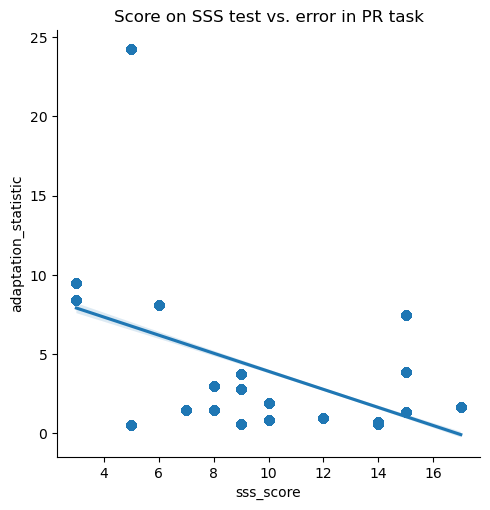

In [41]:
sb.lmplot(data=all_trials_no_out, x='sss_score', y='adaptation_statistic')
plt.title('Score on SSS test vs. error in PR task')

# SPQ Korr

Force: -24    Slope: 0.05414410662224074    p-value: 0.010054798687548265
Force: -15    Slope: 0.06260785088471599    p-value: 0.0006929476453350997
Force: 0    Slope: 0.04774044999830606    p-value: 6.217230399392498e-14
Force: 15    Slope: 0.057424009826061675    p-value: 0.0015034062581545922
Force: 24    Slope: -0.0018335108129098562    p-value: 0.9311639357792794


Text(0.5, 1.0, 'Score on SPQ test vs. average subjective answer')

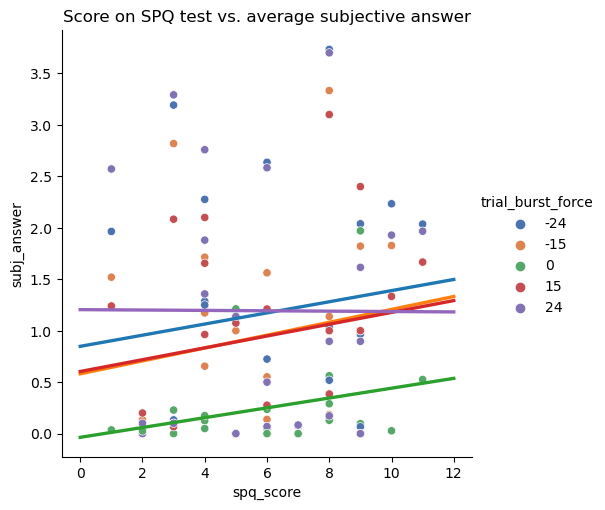

In [42]:
for p_id in p_ids:
    average_force_subj_p.loc[average_force_subj_p['p_id'] == p_id, 'spq_score'] = sss_scores[sss_scores['p_id'] == p_id]['spq_score'].iloc[0]

sb.relplot(data=average_force_subj_p, x='spq_score', y='subj_answer', hue='trial_burst_force', palette='deep')

# regressions
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
forces = [-24, -15, 0, 15, 24]
x_values = np.linspace(0,12,50)
for f,c in zip(forces, colors):
    y = all_trials[(all_trials['trial_burst_force'] == f) & (all_trials['subj_answer'].notna()) & (all_trials['spq_score'].notna())]['subj_answer']
    x = all_trials[(all_trials['trial_burst_force'] == f) & (all_trials['subj_answer'].notna()) & (all_trials['spq_score'].notna())]['spq_score']
    slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
    plt.plot(x_values, x_values * slope + intercept, c=c, lw=2.4)
    print(f"Force: {f}    Slope: {slope}    p-value: {p_value}")


#sb.lmplot(data=all_trials[all_trials['p_id'].isin(responders)], x='sss_score', y='subj_answer')
plt.title('Score on SPQ test vs. average subjective answer')

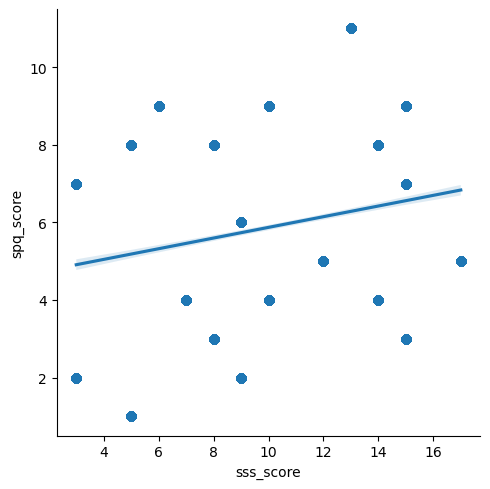

In [43]:
sb.lmplot(data=all_trials, x='sss_score', y='spq_score')

# Sonstiges

## Leistung bei PR

### Scatterplots Positionen nach force

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

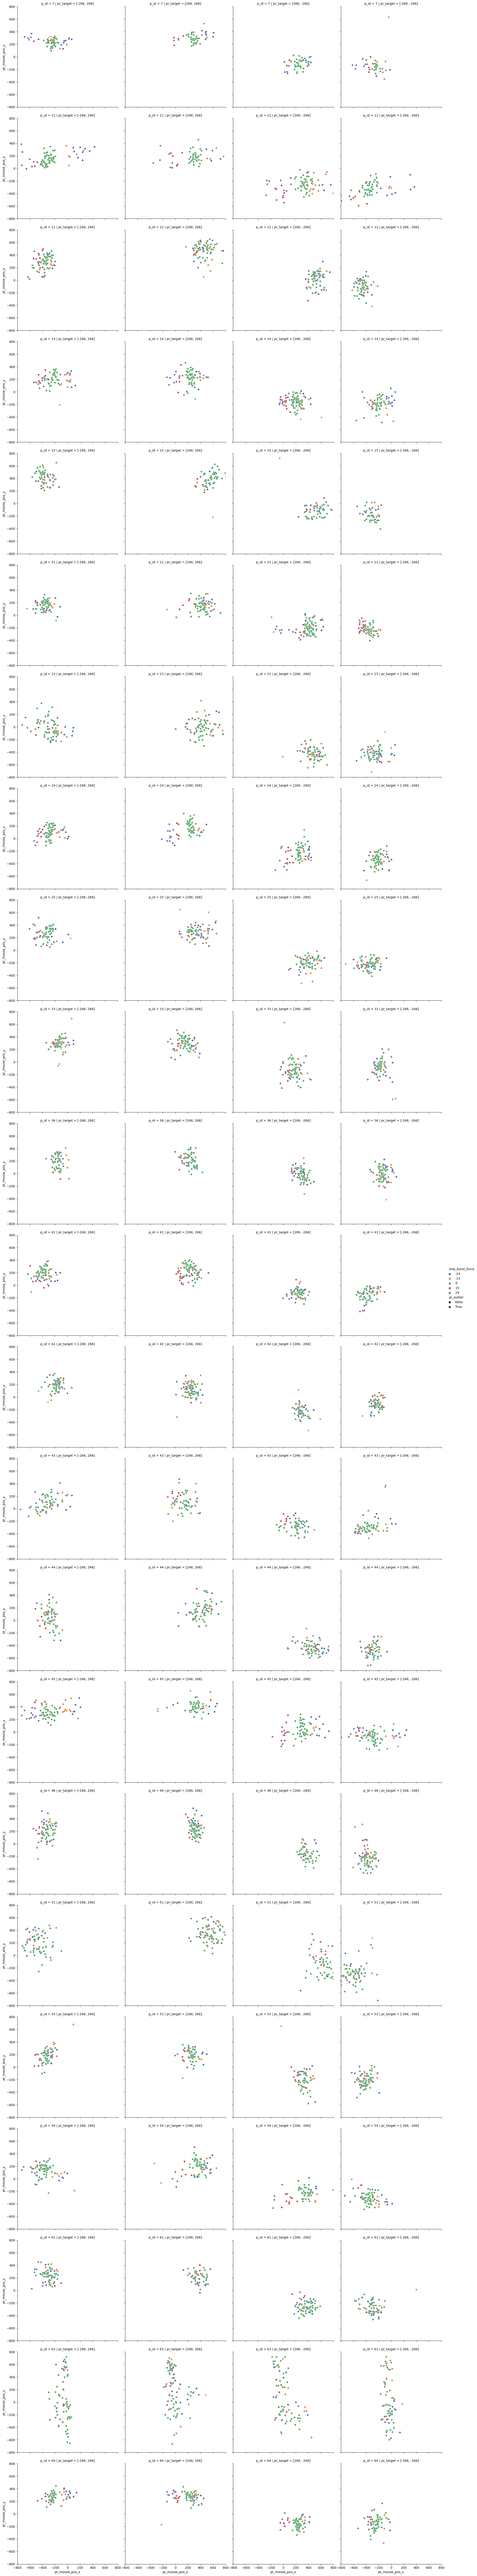

In [45]:
pr_plot = sb.relplot(data=all_trials, x='pr_mouse_pos_x', y='pr_mouse_pos_y', col='pr_target', row='p_id', hue='trial_burst_force', palette='deep', style='pr_outlier')
pr_plot.set(xlim=(-800,800), ylim=(-800,800), aspect=1)

for (p_id, pos), ax in zip(itertools.product(p_ids, all_trials['pr_target'].unique()), pr_plot.axes.flat):
    cc = plt.Circle(ast.literal_eval(pos), 55, color='red', fill=False)
    ax.add_artist(cc)
    comp_value = avg_mouse_pos[(avg_mouse_pos['p_id'] == p_id) & (avg_mouse_pos['pr_target'] == pos)]['comp_value']
    ax.axvline(comp_value, alpha=0.5, ls='--')

### Leistung nach force über Blöcke

In [ ]:
for i, row in all_trials.iterrows():
    all_trials.loc[i,'pr_error_force'] = row['pr_mouse_pos_x'] - avg_mouse_pos[(avg_mouse_pos['p_id'] == row['p_id']) & (avg_mouse_pos['pr_target'] == row['pr_target'])]['comp_value'].iloc[0]
    
plot22 = sb.lmplot(data=all_trials, x="trial_burst_force", y="pr_error_force", row="p_id", hue='block_nr')
plot22.fig.subplots_adjust(top=.98)
plot22.fig.suptitle("x-axis offset averages")
plot22.set(ylim=(-600,600))

### Zero-force und zero-feel

In [ ]:
tmp = []
for x in itertools.product(avg_mouse_pos['p_id'].unique(), avg_mouse_pos['pr_target'].unique()):
    m = all_trials_no_out[(all_trials_no_out['p_id']==x[0]) & (all_trials_no_out['pr_target']==x[1]) & (all_trials_no_out['subj_answer']==0)]['pr_mouse_pos_x'].mean()
    tmp.append(m)

avg_mouse_pos['zero_feel'] = tmp
avg_mouse_pos['force_minus_feel'] = avg_mouse_pos['zero_force'] - avg_mouse_pos['zero_feel']

for pos in list(avg_mouse_pos['pr_target'].unique()):
    melted = avg_mouse_pos[avg_mouse_pos['pr_target'] == pos][['p_id', 'zero_force', 'zero_feel', 'begin_baseline']].melt('p_id', var_name='condition', value_name='average_mouse_x')
    plt.figure()
    sb.barplot(data=melted, x='p_id', y='average_mouse_x', hue='condition')

In [ ]:
# T-test über comp_value und zero-feel
for p_id, m_trial, b_trial, e_trial in zip(p_ids, main_trials, begin_trials, end_trials):
    m_trial_no_out = m_trial[m_trial['pr_outlier'] == False]
    for pos in m_trial_no_out['pr_target'].unique():
        zero_feel_x = m_trial_no_out[(m_trial_no_out['subj_answer'] == 0) & (m_trial_no_out['pr_target'] == pos)]['pr_mouse_pos_x']
        b_x = b_trial[b_trial['pr_target'] == pos]['pr_mouse_pos_x']
        e_x = e_trial[e_trial['pr_target'] == pos]['pr_mouse_pos_x']
        #comp_x = (b_x - e_x)/2
        s_z_b = st.ttest_ind(zero_feel_x, b_x)
        s_z_e = st.ttest_ind(zero_feel_x, e_x)
        pvalue = (s_z_b.pvalue + s_z_e.pvalue)/2
        avg_x_click_ttest.loc[(avg_x_click_ttest['p_id'] == p_id) & (avg_x_click_ttest['pr_target'] == pos), 'pv_zerofeel_comp'] = pvalue
        avg_x_click_ttest.loc[(avg_x_click_ttest['p_id'] == p_id) & (avg_x_click_ttest['pr_target'] == pos), 'z_comp_signif'] = pvalue < 0.05
    
display(avg_x_click_ttest)

**Interpretation**: In den meisten fällen ist der Unterschied zwischen zero_force mean und comp_value nicht signifikant. Das bedeutet, dass die Leistung wenn nichts gespürt wurde der baseline entspricht.

### Scatterplots Positionen nach Gefühl

In [ ]:
for f in [-24, -15, 0, 15, 24]:
    pr_plot = sb.relplot(data=all_trials[all_trials['trial_burst_force']==f], x='pr_mouse_pos_x', y='pr_mouse_pos_y', col='pr_target', row='p_id', hue='subj_answer', palette='deep', style='pr_outlier')
    pr_plot.set(xlim=(-800,800), ylim=(-800,800), aspect=1)
    for (p_id, pos), ax in zip(itertools.product(p_ids, all_trials['pr_target'].unique()), pr_plot.axes.flat):
        cc = plt.Circle(ast.literal_eval(pos), 55, color='red', fill=False)
        ax.add_artist(cc)
        comp_value = avg_mouse_pos[(avg_mouse_pos['p_id'] == p_id) & (avg_mouse_pos['pr_target'] == pos)]['comp_value'].iloc[0]
        ax.axvline(comp_value, alpha=0.5, ls='--')

## Korrigierte Leistung bei PR

### Scatterplots Korrigierte Positionen nach Force

In [ ]:
# (2.4.2)
pr_plot = sb.relplot(data=all_trials_no_out, x='v_pr_x', y='pr_mouse_pos_y', col='pr_target', row='p_id', hue='trial_burst_force', palette='deep')#, style='subj_answer')
pr_plot.set(xlim=(-800,800), ylim=(-800,800), aspect=1)
for (p_id, pos), ax in zip(itertools.product(p_ids, all_trials['pr_target'].unique()), pr_plot.axes.flat):
    cc = plt.Circle(ast.literal_eval(pos), 55, color='red', fill=False)
    ax.add_artist(cc)
    comp_value = avg_mouse_pos[(avg_mouse_pos['p_id'] == p_id) & (avg_mouse_pos['pr_target'] == pos)]['comp_value'].iloc[0]
    ax.axvline(comp_value, alpha=0.5, ls='--')

### Scatterplots Korrigierte Positionen nach Gefühl

In [ ]:
# (2.4.2)
poss = ['[266, 266]','[-266, 266]','[-266, -266]','[266, -266]']
pr_plot = sb.relplot(data=all_trials_no_out[all_trials_no_out['trial_burst_force'] != 0], x='v_pr_x', y='pr_mouse_pos_y', col='pr_target', row='p_id', hue='subj_answer', palette='deep')
pr_plot.set(xlim=(-800,800), ylim=(-800,800), aspect=1)
for (p_id, pos), ax in zip(itertools.product(p_ids, poss), pr_plot.axes.flat):
    cc = plt.Circle(ast.literal_eval(pos), 55, color='red', fill=False)
    ax.add_artist(cc)
    comp_value = avg_mouse_pos[(avg_mouse_pos['p_id'] == p_id) & (avg_mouse_pos['pr_target'] == pos)]['comp_value'].iloc[0]
    ax.axvline(comp_value, alpha=0.5, ls='--')

## SSS Scores vs. Slope aus 2.2

In [ ]:
sss_scores['pr_error_slope'] = pr_error_force['slope']
sb.lmplot(data=sss_scores, x='sss_score', y='pr_error_slope')